In [1]:
a = 2151264638 % 15 
print(a)

8


In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.naive_bayes import GaussianNB
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
df=pd.read_csv("GiaSMP_TS14_5_2024.csv",index_col = 'Ng?y')

In [4]:
df.head()

,9,10
Ng?y,,
1/1/2021,964.4,964.4
1/2/2021,1019.7,1019.7
1/3/2021,988.4,988.4
1/4/2021,1002.1,1002.1
1/5/2021,1061.5,1061.5


In [5]:
feats= ['9', '10']

In [6]:
transformer = PowerTransformer()
X=transformer.fit_transform(df[feats])

In [7]:
pca = PCA(n_components=0.5,random_state=1)
pca.fit(X)
PCA_ds = pd.DataFrame(pca.transform(df[feats]), columns=(["col"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col,365.0,-1471.07671,148.698959,-2213.803152,-1501.087222,-1446.077996,-1397.715129,-1252.485117


Elbow Method to determine the number of clusters to be formed:


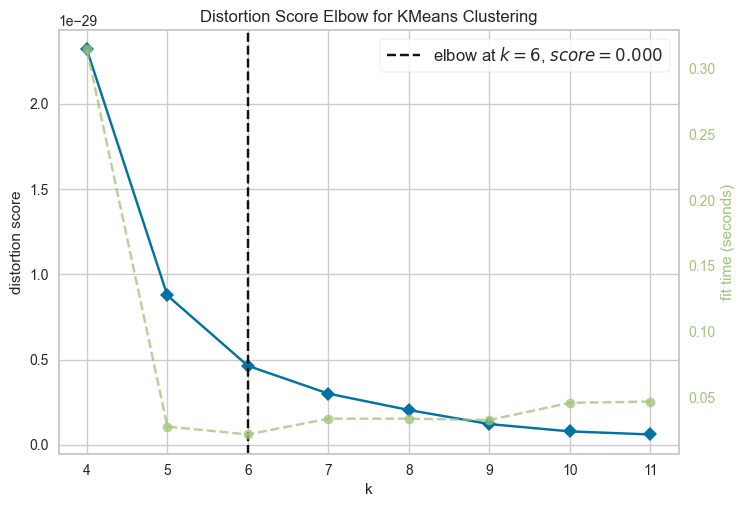

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(4,12))
Elbow_M.fit(X)
Elbow_M.show()

In [9]:
# USING GAUSIAN
BGM = BayesianGaussianMixture(n_components=6,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
PCA_ds["Clusters"] = preds
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds

In [10]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(6)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [11]:
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15


In [12]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [13]:
labels=np.argmax(lgb_preds,axis=1)

In [14]:
df.Predicted=np.argmax(lgb_preds,axis=1)

In [15]:
# USING EDA
# Display basic information about the dataset
print(df.info())

# Display summary statistics
print(df.describe())

# Display the number of missing values in each column
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 1/1/2021 to 31/12/2021
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   9         365 non-null    float64
 1   10        365 non-null    float64
 2   Clusters  365 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.4+ KB
None
                 9           10  Clusters
count   365.000000   365.000000     365.0
mean   1040.278082  1040.277808       0.0
std     105.152979   105.153179       0.0
min     885.700000   885.700000       0.0
25%     988.400000   988.400000       0.0
50%    1022.600000  1022.600000       0.0
75%    1061.500000  1061.500000       0.0
max    1565.500000  1565.500000       0.0
9           0
10          0
Clusters    0
dtype: int64


In [16]:
# Handling missing values (example: filling with mean or removing)
df.fillna(df.mean(), inplace=True)
# data.dropna(inplace=True)  # Alternatively, remove rows with missing values

# Convert data types if needed
# data['column_name'] = data['column_name'].astype('desired_type')

# Remove duplicates
df.drop_duplicates(inplace=True)


In [17]:
# Summary statistics for numerical columns
print(df.describe())

# Summary statistics for categorical columns
print(df.describe())

# Display the distribution of a specific column
print(df.value_counts())


                 9           10  Clusters
count    42.000000    42.000000      42.0
mean   1113.652381  1113.650000       0.0
std     214.608149   214.609854       0.0
min     885.700000   885.700000       0.0
25%     963.625000   963.600000       0.0
50%    1021.150000  1021.150000       0.0
75%    1311.100000  1311.100000       0.0
max    1565.500000  1565.500000       0.0
                 9           10  Clusters
count    42.000000    42.000000      42.0
mean   1113.652381  1113.650000       0.0
std     214.608149   214.609854       0.0
min     885.700000   885.700000       0.0
25%     963.625000   963.600000       0.0
50%    1021.150000  1021.150000       0.0
75%    1311.100000  1311.100000       0.0
max    1565.500000  1565.500000       0.0
9       10      Clusters
885.7   885.7   0           1
1316.8  1316.8  0           1
1061.5  1061.5  0           1
1064.0  1064.0  0           1
1064.1  1064.1  0           1
1066.6  1066.6  0           1
1069.4  1069.4  0           1
1087.5  1

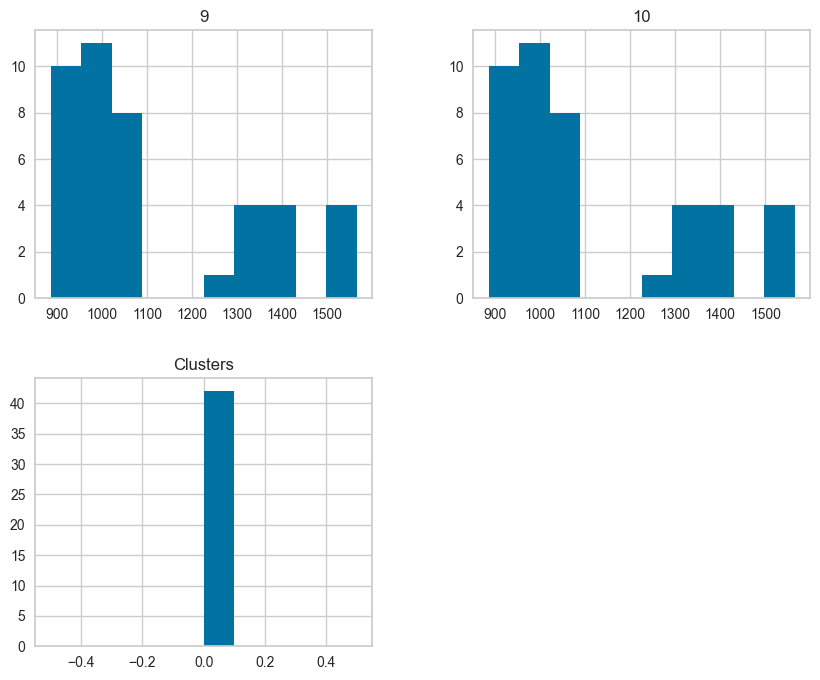

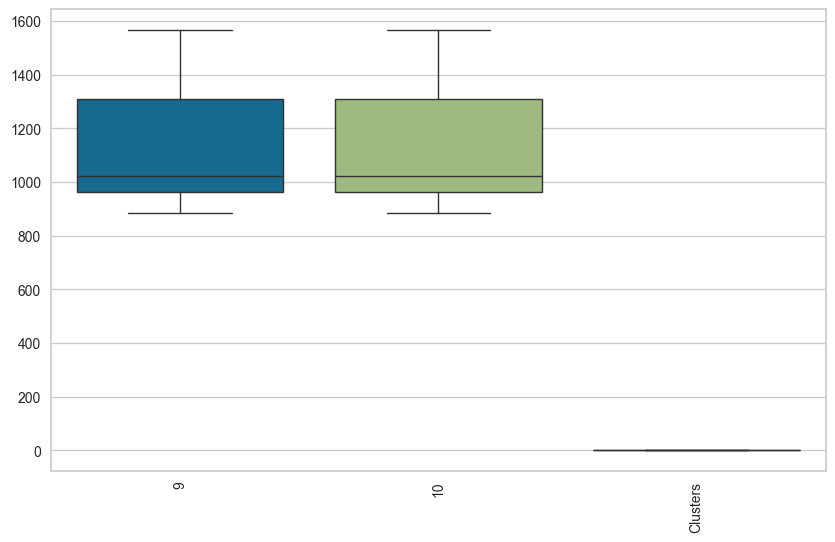

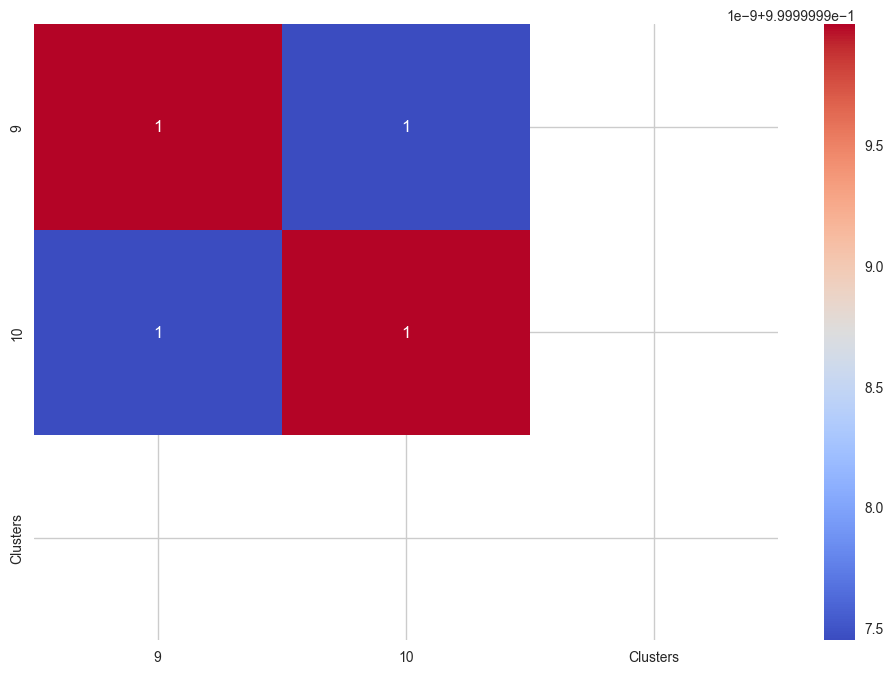

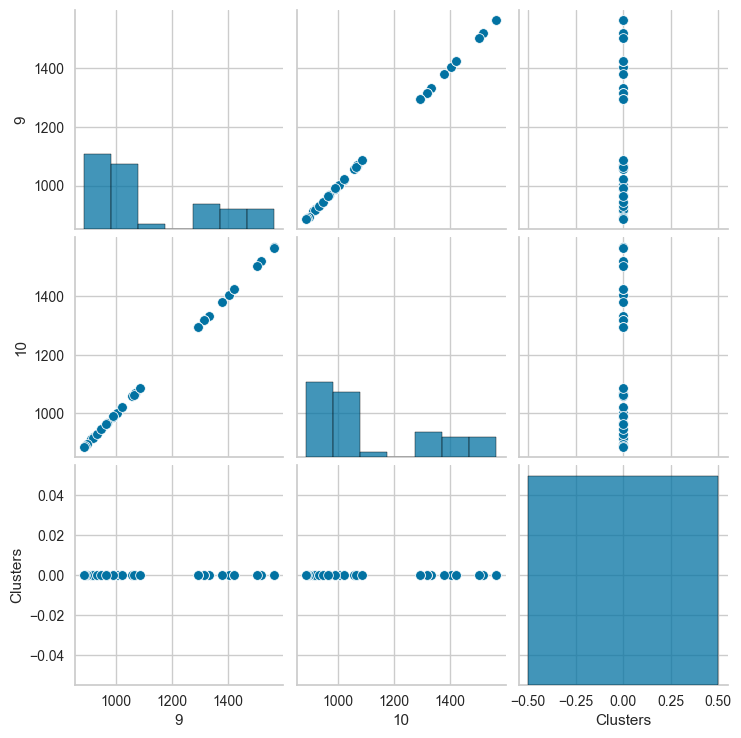

KeyError: 'categorical_column'

<Figure size 1000x600 with 0 Axes>

In [18]:
# Histograms for numerical columns
df.hist(figsize=(10, 8))
plt.show()

# Boxplots to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

# Specific plots for categorical data
plt.figure(figsize=(10, 6))
sns.countplot(df['categorical_column'])
plt.show()

# Scatter plot for two numerical columns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='9', y='10', data=df)
plt.show()


            9   10  Clusters
9         1.0  1.0       NaN
10        1.0  1.0       NaN
Clusters  NaN  NaN       NaN


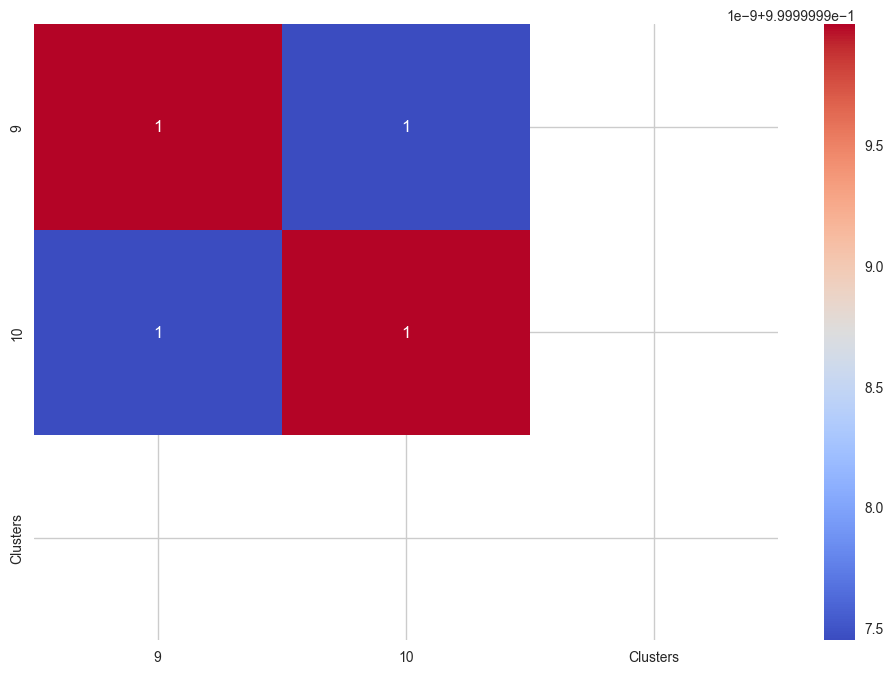

In [19]:
# Calculate correlation matrix
corr_matrix = df.corr()

# Display correlation matrix
print(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [20]:
# Using IQR to detect outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df_outliers_filtered = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f'Original data shape: {df.shape}')
print(f'Data shape after outlier removal: {df_outliers_filtered.shape}')


Original data shape: (42, 3)
Data shape after outlier removal: (42, 3)


In [21]:
# USING ARIMA

from statsmodels.tsa.arima.model import ARIMA
# Load dataset
data = pd.read_csv('GiaSMP_TS14_5_2024.csv', index_col='Ng?y')

In [22]:
train_size = int(len(data) * 0.8)  # 80% for training, 20% for testing
train_data, test_data = data[:train_size], data[train_size:]


In [23]:
# Define ARIMA model parameters (p, d, q)
p = 5  # Autoregression (AR) order
d = 1  # Integrated (I) order (degree of differencing)
q = 0  # Moving Average (MA) order

# Initialize and fit ARIMA model
arima_model = ARIMA(train_data, order=(p, d, q))
arima_result = arima_model.fit()


C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: SARIMAX models require univariate `endog`. Got shape (292, 2).

In [24]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')


NameError: name 'predictions' is not defined

NameError: name 'predictions' is not defined

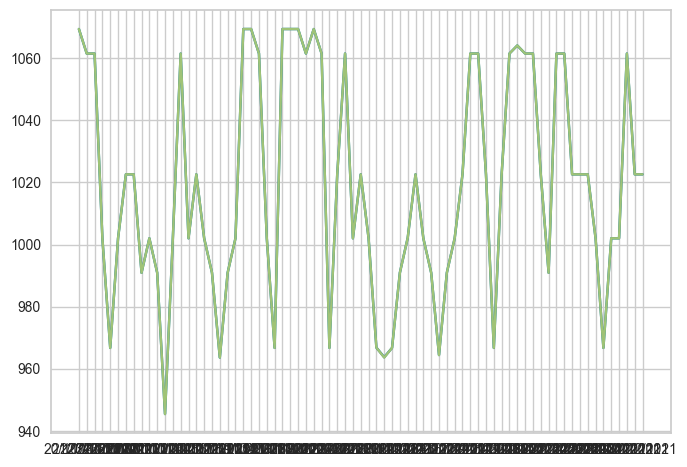

In [25]:
# Plot observed vs. predicted values
plt.plot(test_data, label='Observed')
plt.plot(test_data.index, predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()


In [ ]:
pip install statsmodels